# Mark rooftops with u-net

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/M_DV_V2022

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/M_DV_V2022


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, Flatten, \
                         UpSampling2D, Conv2DTranspose, MaxPooling2D, \
                         Dropout, Concatenate, BatchNormalization, Activation, \
                         concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.image import resize

import keras.backend as K
import tensorflow as tf

from unet_detection.models.vanilla_unet import vanilla_unet
#from unet_detection.models.unet_2input import unet_2input
#from unet_detection.models.unet_2input_deep import unet_2input_deep
#from unet_detection.models.double_unet import double_unet
#from unet_detection.models.triple_unet import triple_unet
#from unet_detection.models.serie_unet import serie_unet
#from unet_detection.models.triple_serie_unet import triple_serie_unet
#from unet_detection.models.unet_plus_plus import unet_plus_plus

### Load data

In [3]:
X_train = np.load("data/u_net_roofs/X_data.npy") 
X_70_train = np.load("data/u_net_roofs/X_70_data.npy")
y_train = np.load("data/u_net_roofs/y_data.npy")

X_val = np.load("data/u_net_roofs/X_data_val.npy")
X_70_val = np.load("data/u_net_roofs/X_70_data_val.npy")
y_val = np.load("data/u_net_roofs/y_data_val.npy")

X_test = np.load("data/u_net_roofs/X_data_test.npy")
X_70_test = np.load("data/u_net_roofs/X_70_data_test.npy")
y_test = np.load("data/u_net_roofs/y_data_test.npy")


In [4]:
def redesign_y(y):
  n,r1,c1,d = y.shape
  # Adds a new dimension of layer too have two class problem.
  yy = np.append(y, np.zeros((n, r1, c1,d)), axis=3)
  for i in range(int(y.max()-1)):  
    yy = np.append(yy, np.zeros((n, r1, c1,d)), axis=3)
  #yy[yy >= 0.001] = 1
  yy1 = yy.copy()
  yy1[:,:,:,0] = 0 # reset map
  for i in range(n):
    values = yy[i,:,:,0]
    for r in range(r1):
      for c in range(c1):
        value = yy[i,r,c,0]
        yy1[i,r,c,int(value)] = 1

  return yy1

In [5]:
y_train = redesign_y(y_train)
y_val = redesign_y(y_val)
y_test = redesign_y(y_test)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(1000, 128, 128, 2)
(200, 128, 128, 2)
(500, 128, 128, 2)


In [ ]:
#When raw data
X_train[:,:,:,:-1] /= 100
X_val[:,:,:,:-1] /= 100
X_test[:,:,:,:-1] /= 100
X_70_train[:,:,:,:-1] /= 2000
X_70_val[:,:,:,:-1] /= 2000
X_70_test[:,:,:,:-1] /= 2000

In [ ]:
# Scale image down so each border is the same size when upsizing!
X_70_train = X_70_train[:,4:-4,4:-4,:]
X_70_val = X_70_val[:,4:-4,4:-4,:]
X_70_test = X_70_test[:,4:-4,4:-4,:]

In [19]:
print(X_train.shape)
print(X_70_train.shape)

(1000, 128, 128, 6)
(1000, 64, 64, 5)


### Show data - 5 random images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[820 178 330 702 309]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


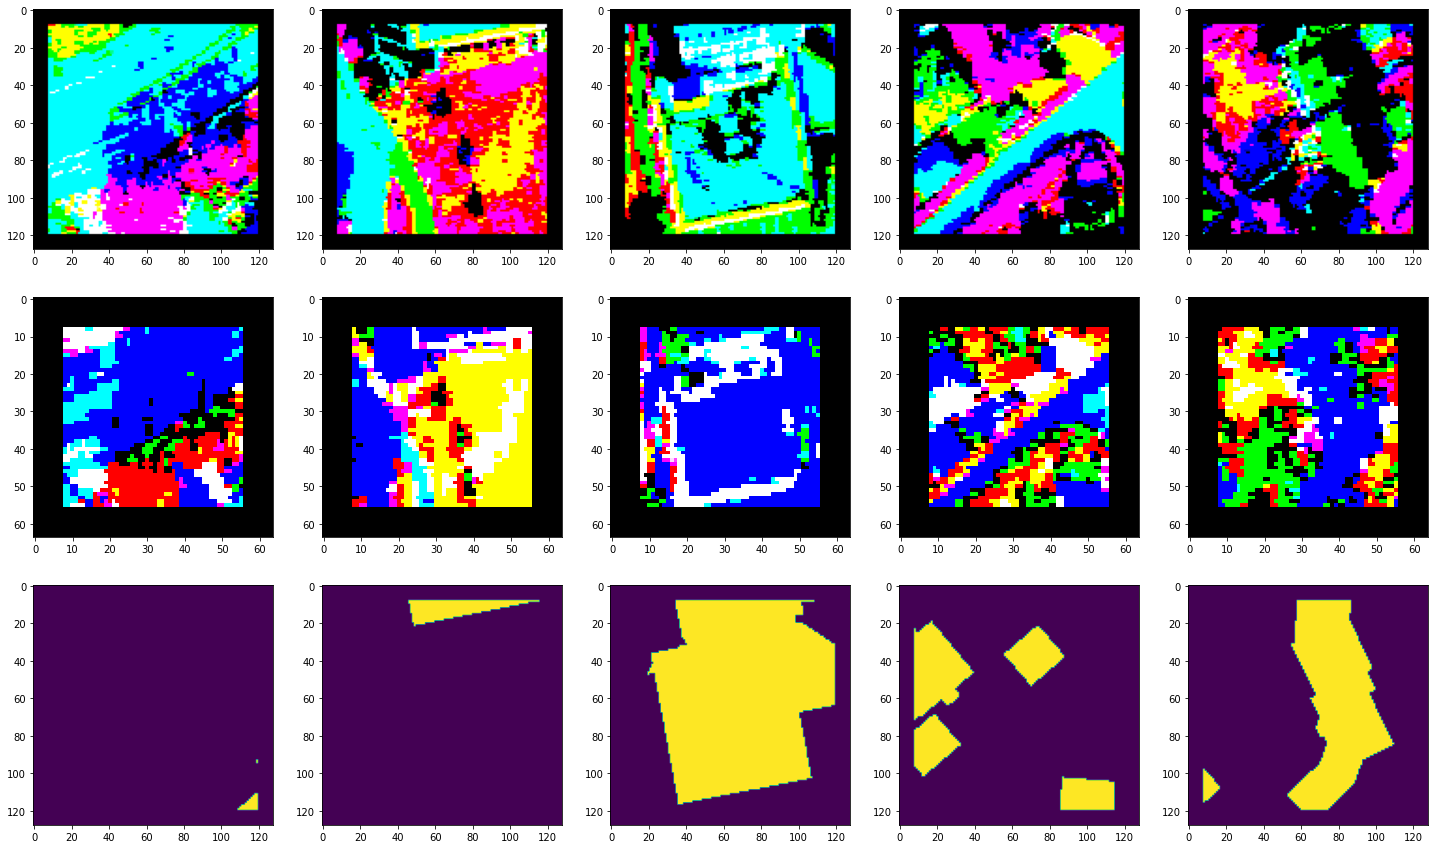

In [6]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize = (25,15))

indx = np.random.randint(0,high=X_train.shape[0],size=5)
print(indx)
for i in range(5):
    #ax[0,i].imshow(np.dstack((X_train[indx[i]][:,:,76],
    #                          X_train[indx[i]][:,:,46],
    #                          X_train[indx[i]][:,:,21])))
    ax[0,i].imshow(X_train[indx[i]][:,:,0:3])
    ax[1,i].imshow(X_70_train[indx[i]][:,:,0:3])
    #ax[1,i].imshow(np.dstack((X_70_train[indx[i]][:,:,137],
    #                          X_70_train[indx[i]][:,:,194],
    #                          X_70_train[indx[i]][:,:,207])))
    ax[2,i].imshow(y_train[indx[i]].argmax(axis=2))
plt.show()

### Make u net

In [6]:
vUnet = vanilla_unet()

In [7]:
input_img1 = Input(shape=(128,128,X_train.shape[3]))
input_img2 = Input(shape=(56,56,X_70_train.shape[3]))


model = vUnet.get_unet(input_img1, input_img2,
                                 n_classes=2, last_activation='softmax')


model.compile(optimizer='adam',
                         loss='binary_crossentropy',
                         metrics=[vUnet.jacard, vUnet.dice_coef, 'accuracy'])

### Train net

In [8]:
h = model.fit(X_train,
              y_train, 
              validation_data=(X_val,y_val), 
              batch_size=16,
              epochs=50)

Epoch 1/50
63/63 [==============================] - 7s 51ms/step - loss: 0.5687 - jacard: 0.5070 - dice_coef: 0.6651 - accuracy: 0.8086 - val_loss: 149.6471 - val_jacard: 0.0934 - val_dice_coef: 0.1707 - val_accuracy: 0.1755
Epoch 2/50
63/63 [==============================] - 2s 37ms/step - loss: 0.3812 - jacard: 0.6891 - dice_coef: 0.8152 - accuracy: 0.9259 - val_loss: 2.6788 - val_jacard: 0.4444 - val_dice_coef: 0.6152 - val_accuracy: 0.6771
Epoch 3/50
63/63 [==============================] - 2s 37ms/step - loss: 0.2808 - jacard: 0.7967 - dice_coef: 0.8866 - accuracy: 0.9431 - val_loss: 0.8369 - val_jacard: 0.6343 - val_dice_coef: 0.7760 - val_accuracy: 0.8166
Epoch 4/50
63/63 [==============================] - 2s 37ms/step - loss: 0.2190 - jacard: 0.8538 - dice_coef: 0.9210 - accuracy: 0.9494 - val_loss: 0.2825 - val_jacard: 0.8061 - val_dice_coef: 0.8926 - val_accuracy: 0.9235
Epoch 5/50
63/63 [==============================] - 2s 37ms/step - loss: 0.1737 - jacard: 0.8879 - dice_co

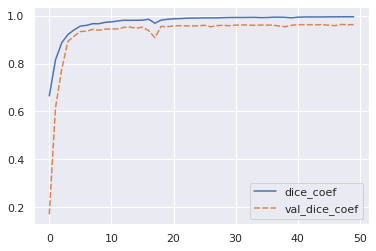

In [10]:
sns.set_theme()
sns.lineplot(data={key:(h.history[key]) for key in ['dice_coef', 'val_dice_coef']})
#h.history[['loss', 'val_loss']]

### Validate prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


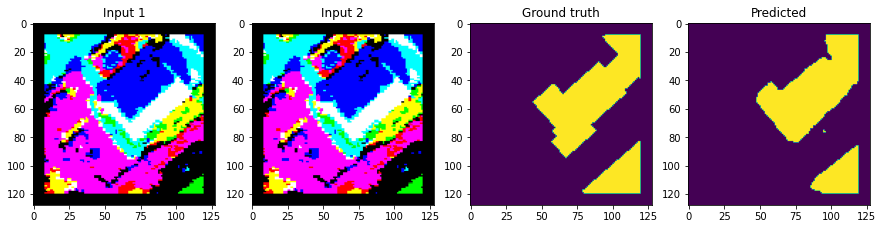

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


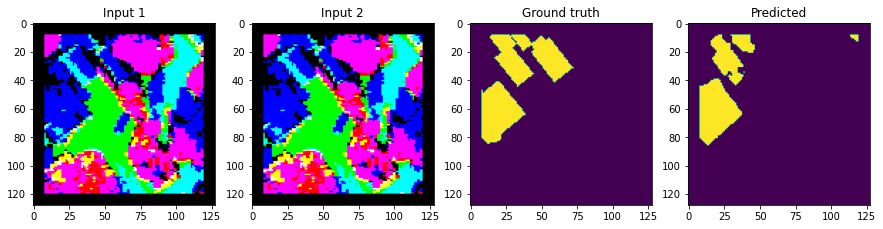

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


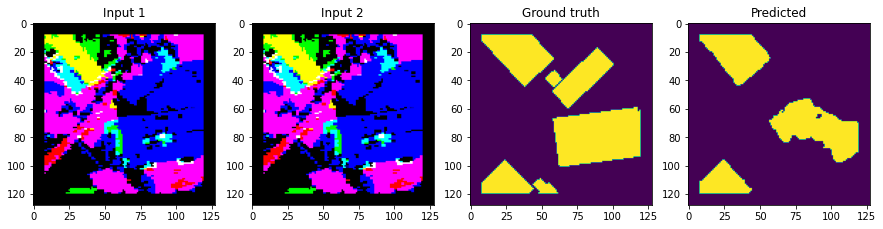

In [32]:
sns.reset_orig()
for _ in range(3):
  x = np.random.randint(X_val.shape[0])
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1,ncols=4, figsize = (15,15))
  #ax1.imshow(np.dstack((X_val[x:x+1][0][:,:,76],
  #                      X_val[x:x+1][0][:,:,46],
  #                      X_val[x:x+1][0][:,:,21])))
  
  ax1.imshow(X_val[x:x+1][0][:,:,0:3])
  ax1.set_title("Input 1")

  ax2.imshow(X_val[x:x+1][0][:,:,0:3])
  #ax2.imshow(np.dstack((X_70_val[x:x+1][0][:,:,137],
  #                      X_70_val[x:x+1][0][:,:,194],
  #                      X_70_val[x:x+1][0][:,:,207])))
  ax2.set_title("Input 2")


  ax3.imshow(y_val[x:x+1][0].argmax(axis=2))
  ax3.set_title("Ground truth")
  pred = model.predict([X_val[x:x+1]])[0].argmax(axis=2)
  ax4.imshow(pred)
  ax4.set_title("Predicted")
  plt.show()

## Test on unseen data

In [34]:
pred = model.predict([X_test])

In [14]:
print("Metrics on whole pred and useen")
print(f"f1 score: {f1_score(y_test.argmax(axis=3).flatten(), pred.argmax(axis=3).flatten())}")
print(f"acc score: {accuracy_score(y_test.argmax(axis=3).flatten(), pred.argmax(axis=3).flatten())}")

Metrics on whole pred and useen
f1 score: 0.7579384427159961
acc score: 0.9447894287109375


In [27]:
pred.argmax(axis=3).max()

1

In [22]:
vUnet.dice_coef(y_test.argmax(axis=3), pred.argmax(axis=3))

TypeError: ignored

In [37]:
pred[x:x+1][0].argmax(axis=2).shape

(128, 128)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


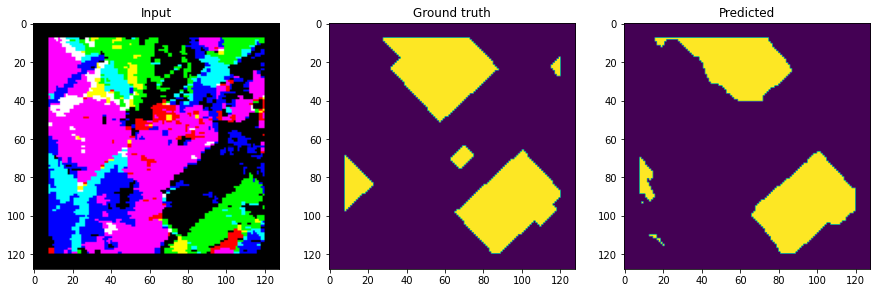

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Acc score: 0.95733642578125
f1 score: 0.8914427706165553


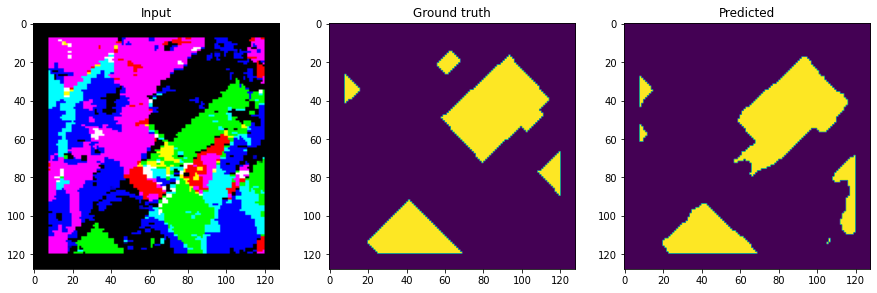

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Acc score: 0.9638671875
f1 score: 0.8905325443786982


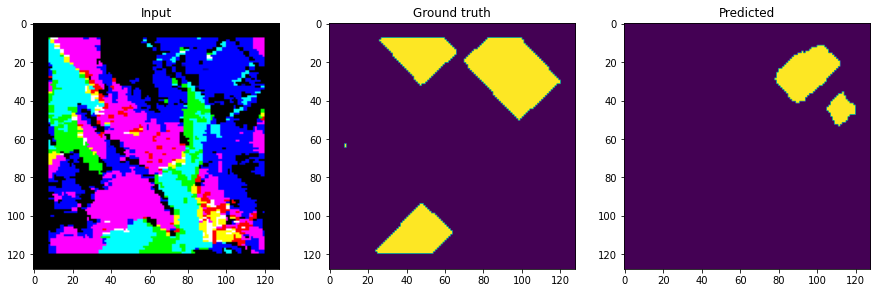

Acc score: 0.88165283203125
f1 score: 0.3751208507895585


In [38]:
for _ in range(3):
  x = np.random.randint(pred.shape[0])
  fig, (ax1, ax2, ax3) = plt.subplots(nrows=1,ncols=3, figsize = (15,15))
  #ax1.imshow(np.dstack((X_test[x:x+1][0][:,:,76],
  #                      X_test[x:x+1][0][:,:,46],
  #                      X_test[x:x+1][0][:,:,21])))
  ax1.imshow(X_test[x:x+1][0][:,:,0:3])
  ax1.set_title("Input")
  ax2.imshow(y_test[x:x+1][0].argmax(axis=2))
  ax2.set_title("Ground truth")
  ax3.imshow(pred[x:x+1][0].argmax(axis=2))
  ax3.set_title("Predicted")
  plt.show()

  # Metrics  w threshold:
  #pred[x:x+1,:,:,0][pred[x:x+1,:,:,0] > .5] = 1
  #pred[x:x+1,:,:,0][pred[x:x+1,:,:,0] <= .5] = 0
  #pred[x:x+1,:,:,1][pred[x:x+1,:,:,1] > .5] = 1
  #pred[x:x+1,:,:,1][pred[x:x+1,:,:,1] <= .5] = 0

  print(f"Acc score: {accuracy_score(y_test[x:x+1][0].argmax(axis=2).flatten(),\
                                     pred[x:x+1][0].argmax(axis=2).flatten())}")
  print(f"f1 score: {f1_score(y_test[x:x+1][0].argmax(axis=2).flatten(),\
                                     pred[x:x+1][0].argmax(axis=2).flatten())}")
  
  